In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, GlobalMaxPooling1D

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-09-22 07:36:18--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-09-22 07:36:18 (19.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
with open('/content/input.txt') as f:
    data = f.read()

corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")

for i in range(5):
  print(corpus[i])

There are 40001 lines of sonnets

The first 5 lines look like this:

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
corpus[0]

'first citizen:'

In [6]:
tokenizer.texts_to_sequences(corpus[0])

[[], [4], [6237], [], [], [], [4163], [4], [], [4], [], [], [], []]

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[88, 269]]

In [8]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[88, 269]

In [9]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1,len(token_list)):
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)

    return input_sequences

In [10]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[88, 269]]

In [11]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[139, 35],
 [139, 35, 969],
 [139, 35, 969, 143],
 [139, 35, 969, 143, 668],
 [139, 35, 969, 143, 668, 127],
 [139, 35, 969, 143, 668, 127, 15],
 [139, 35, 969, 143, 668, 127, 15, 102]]

In [12]:
input_sequences = n_gram_seqs(corpus, tokenizer)

max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 171312
maximum length of sequences is: 16


In [13]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = pad_sequences(input_sequences,padding='pre',maxlen=maxlen)
    return padded_sequences

In [14]:
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[ 88, 269]], dtype=int32)

In [15]:
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0, 139,  35],
       [  0,   0,   0,   0,   0, 139,  35, 969],
       [  0,   0,   0,   0, 139,  35, 969, 143],
       [  0,   0,   0, 139,  35, 969, 143, 668],
       [  0,   0, 139,  35, 969, 143, 668, 127],
       [  0, 139,  35, 969, 143, 668, 127,  15],
       [139,  35, 969, 143, 668, 127,  15, 102]], dtype=int32)

In [16]:
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (171312, 16)


In [17]:
def features_and_labels(input_sequences, total_wrds):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels,total_wrds)

    return features, one_hot_labels

In [18]:
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (1, 12633)

features look like this:



array([[88]], dtype=int32)

In [19]:
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (171312, 15)
labels have shape: (171312, 12633)


In [24]:
def create_model(total_words, max_sequence_len):
    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Conv1D(100, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [25]:
model = create_model(total_words, max_sequence_len)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 100)           1263300   
                                                                 
 bidirectional_3 (Bidirecti  (None, 15, 200)           160800    
 onal)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 100)           60100     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 256)               25856     
                                                                 
 dense_7 (Dense)             (None, 12633)            

In [26]:
history = model.fit(features, labels, epochs=100, steps_per_epoch = 500, verbose=1)

Epoch 1/100
500/500 [==============================] - 44s 80ms/step - loss: 6.9348 - accuracy: 0.0350
Epoch 2/100
500/500 [==============================] - 39s 77ms/step - loss: 6.4036 - accuracy: 0.0549
Epoch 3/100
500/500 [==============================] - 38s 76ms/step - loss: 6.0854 - accuracy: 0.0771
Epoch 4/100
500/500 [==============================] - 38s 76ms/step - loss: 5.8473 - accuracy: 0.0901
Epoch 5/100
500/500 [==============================] - 38s 77ms/step - loss: 5.6609 - accuracy: 0.0991
Epoch 6/100
500/500 [==============================] - 38s 76ms/step - loss: 5.4934 - accuracy: 0.1061
Epoch 7/100
500/500 [==============================] - 38s 75ms/step - loss: 5.3364 - accuracy: 0.1129
Epoch 8/100
500/500 [==============================] - 38s 75ms/step - loss: 5.1758 - accuracy: 0.1193
Epoch 9/100
500/500 [==============================] - 38s 75ms/step - loss: 5.0052 - accuracy: 0.1261
Epoch 10/100
500/500 [==============================] - 37s 75ms/step - l

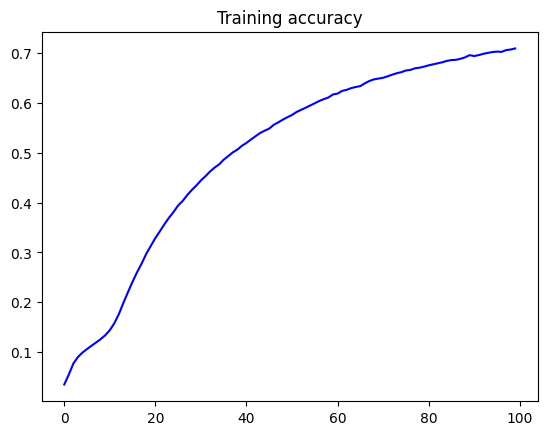

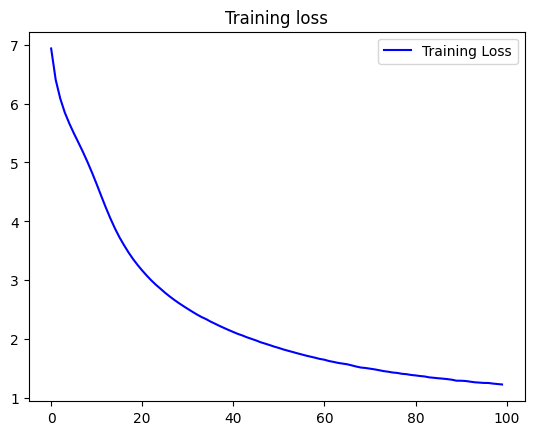

In [27]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [30]:
seed_text = "I am dead"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list)
    predicted = np.argmax(predicted, axis=-1).item()
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 27ms/step
I am dead sir that is it not to me if i go confess to her poor suit and lead me to me ' i find lest i do do't awhile to him good cunning for she did due a velvet is so very very she i hope now now she now unto a virtues you are good not good amends i have but good not a daughter to the men be two and a friend and a flower to night herself the point to hell to bed whose tongue their dreams to do't but it hath too much matter mercy then need


In [32]:
model.save('model_v1.keras')

from google.colab import files
files.download('model_v1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>